## Day 3: Deep Neural Operators

## Table of Contents
#### 1. [DeepONet for Antiderivative Operators in TF2.0](#DeepONet-for-Antiderivative-Operators-in-TF2.0)
#### 1. [DeepONet for Antiderivative Operators in JAX](#DeepONet-for-Antiderivative-Operators-in-JAX)
#### 2. [FNO for Burger's Equation](#Fourier-Neural-Operator-(FNO)-for-Burgers-Equation)

## DeepONet for Antiderivative Operators in TF2.0

In [1]:
import tensorflow.compat as tf
import numpy as np
import scipy.io as io
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io as io
import sys
sys.path.insert(0, 'Utilities/')
import os

# from plotting impo
# rt newfig, savefig
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec


d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
v_train, x_train, u_train = d["X"][0], d["X"][1], d["y"]

d = np.load("antiderivative_aligned_test.npz", allow_pickle=True)
v_test, x_test, u_test = d["X"][0], d["X"][1], d["y"]


####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1,1)
#gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
ax.plot(x_train, v_train[10,:], '-k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_train[10,:], '-b', lw=2.0, label="$u(x)$")
ax.plot(x_train, v_test[100,:], '--k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_test[100,:], '--b', lw=2.0, label="$u(x)$")
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$v \sim \mathcal{GP}(0, cov(x,x))$', fontsize = 10)
#ax.set_xlim([0,1.2])
#ax.set_ylim([-1.1,1.1])
#ax.axis('square')
plt.savefig("Data.png", dpi=300)




/home/dmsm/a.brugnoli/anaconda3/envs/pinn_pikan/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [2]:
import os
import time
import tensorflow as tf
import numpy as np
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
np.random.seed(1234)
import sys

class DNN:
    def __init__(self):
        pass
    #initialization for DNNs
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2.0/(in_dim+out_dim))
            weight = tf.Variable(tf.random.truncated_normal(shape=(in_dim, out_dim), stddev = std))
            bias = tf.Variable(tf.random.truncated_normal(shape=(1, out_dim), stddev = std))
            W.append(weight)
            b.append(bias)
        return W, b

    def fnn_B(self, X, W, b):
        A = X
        A = tf.cast(A, dtype=tf.float32)
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        return Y
    
    def fnn_T(self, X, W, b):
        A = X #2.*(X - Xmin)/(Xmax - Xmin) - 1.0
        A = tf.cast(A, dtype=tf.float32)
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        return Y
    
#Load Training Data
d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
v_train, x_train, u_train = d["X"][0], d["X"][1], d["y"]


d = np.load("antiderivative_aligned_test.npz", allow_pickle=True)
v_test, x_test, u_test = d["X"][0], d["X"][1], d["y"]

#input dimension for Branch Net
u_dim = 100

#output dimension for Branch and Trunk Net
G_dim = 100

#Branch Net
layers_f = [u_dim] + [40]*2 + [G_dim]

# Trunk dim
x_dim = 1

#Trunk Net
layers_x = [x_dim] + [40]*2 + [G_dim]

model = DNN()

def train_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, opt):
    train_vars = W_branch + b_branch + W_trunk + b_trunk
    with tf.GradientTape() as tape:
        tape.watch([W_branch, b_branch, W_trunk, b_trunk])
        u_out_branch = model.fnn_B(v, W_branch, b_branch)
        u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)       
        u_pred = tf.einsum('ij,kj->ik', u_out_branch, u_out_trunk)
        loss = tf.reduce_mean(tf.square(u_pred - u))        
    grads = tape.gradient(loss, train_vars)
    opt.apply_gradients(zip(grads, train_vars))
    return loss, u_pred 

def test_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, opt):
    x_test_tf = tf.convert_to_tensor(x, dtype=tf.float32)
    v_test_tf = tf.convert_to_tensor(v, dtype=tf.float32)
    u_test_tf = tf.convert_to_tensor(u, dtype=tf.float32)
    u_out_branch = model.fnn_B(v_test_tf, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x_test_tf, W_trunk, b_trunk)       
    u_pred = tf.einsum('ij,kj->ik', u_out_branch, u_out_trunk)
    loss = tf.reduce_mean(tf.square(u_pred - u))        
    return loss, u_pred 

    
W_branch, b_branch = model.hyper_initial(layers_f)
W_trunk, b_trunk =   model.hyper_initial(layers_x)

n = 0
nmax = 10000
lr = 5e-4
start_time = time.perf_counter()
time_step_0 = time.perf_counter()
optimizer = tf.optimizers.Adam(learning_rate=lr)
                        
train_err_list = []
test_err_list = []
train_loss_list = []
test_loss_list = []

while n <= nmax:
    x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    v_train_tf = tf.convert_to_tensor(v_train, dtype=tf.float32)
    u_train_tf = tf.convert_to_tensor(u_train, dtype=tf.float32)
    loss_train, u_train_pred = train_step(model, W_branch, b_branch, W_trunk, \
                                          b_trunk, v_train_tf, x_train_tf, u_train_tf, \
                            optimizer)
    err_train = np.mean(np.linalg.norm(u_train - u_train_pred, 2, axis=1)/\
                np.linalg.norm(u_train , 2, axis=1))
    
    loss_test, u_test_pred = test_step(model, W_branch, b_branch, W_trunk, b_trunk, v_test, x_test, u_test, \
                            optimizer)
    err_test = np.mean(np.linalg.norm(u_test - u_test_pred, 2, axis=1)/\
            np.linalg.norm(u_test , 2, axis=1))
    
    if n % 100 == 0:
        print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}")
    train_err_list.append(err_train)
    test_err_list.append(err_test)
    train_loss_list.append(loss_train)
    test_loss_list.append(loss_test)     
    n = n + 1

    


/home/dmsm/a.brugnoli/anaconda3/envs/pinn_pikan/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


train_loss = np.array(train_loss_list)
test_loss =  np.array(test_loss_list)
plot_int = 100

ep = np.arange(0,nmax+1,1)
ep = ep[::plot_int]

train_loss_plot = train_loss[::plot_int]
test_loss_plot = train_loss[::plot_int]



gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_ylim([10**-5, 1])
ax.semilogy(ep, train_loss_plot, '--b', lw=2.0, label="Train")
ax.semilogy(ep, test_loss_plot, '-k', lw=1.0, label="Test")
plt.legend()
plt.savefig("Loss.png", dpi=300)
plt.show()




NameError: name 'np' is not defined

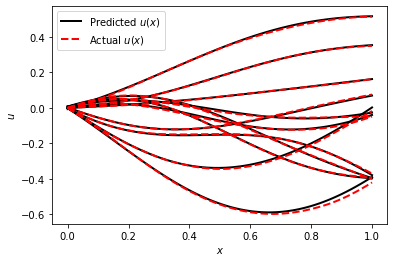

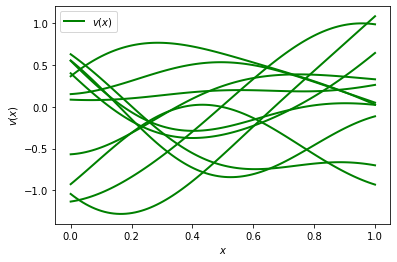

In [4]:
####
gs1 = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs1[:, :])

ax1.plot(x_test, u_test_pred[20, :], '-k', lw=2.0, label="Predicted $u(x)$")

for i in range(10,20):
    ax1.plot(x_test, u_test_pred[i, :], '-k', lw=2.0)

ax1.plot(x_test, u_test[20, :], '--r', lw=2.0, label="Actual $u(x)$")

for i in range(10,20):
    ax1.plot(x_train,u_test[i, :], '--r', lw=2.0)



ax1.set_xlabel('$x$')
ax1.set_ylabel('$u$')
ax1.legend(frameon=True, loc = 'best')
plt.savefig("predicted_and_deeponet.png", dpi=300)
plt.show()

####
gs2 = gridspec.GridSpec(1,1)
ax2 = plt.subplot(gs2[:, :])

ax2.plot(x_test, v_test[20, :], '-g', lw=2.0, label="$v(x)$")
for i in range(10,20):
    ax2.plot(x_test, v_test[i, :], '-g', lw=2.0)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$v(x)$')
ax2.legend(frameon=True, loc = 'best')
plt.savefig("forcing.png", dpi=300)

## PI-DeepONet for Antiderivative Operators in TF

In [6]:
import os
import time
import tensorflow as tf
import numpy as np
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
np.random.seed(1234)
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


class DNN:
    def __init__(self):
        pass
    #initialization for DNNs
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2.0/(in_dim+out_dim))
            weight = tf.Variable(tf.random.truncated_normal(shape=(in_dim, out_dim), stddev = std))
            bias = tf.Variable(tf.random.truncated_normal(shape=(1, out_dim), stddev = std))
            W.append(weight)
            b.append(bias)
        return W, b

    def fnn_B(self, X, W, b):
        A = X
        A = tf.cast(A, dtype=tf.float32)
        L = len(W)
        for i in range(L-1):
            A = tf.nn.relu(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        return Y
    
    def fnn_T(self, X, W, b):
        A = X #2.*(X - Xmin)/(Xmax - Xmin) - 1.0
        A = tf.cast(A, dtype=tf.float32)
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        return Y
    
    
#Load Training Data
d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
v_train, x_train, u_train = d["X"][0], d["X"][1], d["y"]


d = np.load("antiderivative_aligned_test.npz", allow_pickle=True)
v_test, x_test, u_test = d["X"][0], d["X"][1], d["y"]

#input dimension for Branch Net
u_dim = 100

#output dimension for Branch and Trunk Net
G_dim = 100

#Branch Net
layers_f = [u_dim] + [40]*4 + [G_dim]

# Trunk dim
x_dim = 1

#Trunk Net
layers_x = [x_dim] + [40]*4 + [G_dim]

model = DNN()

@tf.function()
def train_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, opt):
    train_vars = W_branch + b_branch + W_trunk + b_trunk
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_branch, b_branch, W_trunk, b_trunk, x])
        u_out_branch = model.fnn_B(v, W_branch, b_branch)
        u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)       
        u_pred = tf.einsum('ij,kj->ik', u_out_branch, u_out_trunk)
        loss_data = tf.reduce_mean(tf.square(u_pred - u))        
        loss_phys = 0.0
        #print(tf.shape(v))
        for i in range(0, 10):      
            u_p = u_pred[i]
            u_o = v[i]
            res = tape.gradient(u_p, x)
            loss_phys += tf.reduce_mean(tf.square(res - u_o))
            loss = loss_phys + loss_data
        grads = tape.gradient(loss, train_vars)
        opt.apply_gradients(zip(grads, train_vars))
        return loss_data, u_pred 

def test_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, opt):
    x_test_tf = tf.convert_to_tensor(x, dtype=tf.float32)
    v_test_tf = tf.convert_to_tensor(v, dtype=tf.float32)
    u_test_tf = tf.convert_to_tensor(u, dtype=tf.float32)
    u_out_branch = model.fnn_B(v_test_tf, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x_test_tf, W_trunk, b_trunk)       
    u_pred = tf.einsum('ij,kj->ik', u_out_branch, u_out_trunk)
    loss = tf.reduce_mean(tf.square(u_pred - u))        
    return loss, u_pred 

    
W_branch, b_branch = model.hyper_initial(layers_f)
W_trunk, b_trunk =   model.hyper_initial(layers_x)

n = 0
nmax = 10000
lr = 1e-4
start_time = time.time()
time_step_0 = time.time()
optimizer = tf.optimizers.Adam(learning_rate=lr)
                        
train_err_list = []
test_err_list = []
train_loss_list = []
test_loss_list = []

while n <= nmax:
    x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    v_train_tf = tf.convert_to_tensor(v_train, dtype=tf.float32)
    u_train_tf = tf.convert_to_tensor(u_train, dtype=tf.float32)
    loss_train, u_train_pred = train_step(model, W_branch, b_branch, W_trunk, \
                                          b_trunk, v_train_tf, x_train_tf, u_train_tf, \
                            optimizer)
    err_train = np.mean(np.linalg.norm(u_train - u_train_pred, 2, axis=1)/\
                np.linalg.norm(u_train , 2, axis=1))
    
    loss_test, u_test_pred = test_step(model, W_branch, b_branch, W_trunk, b_trunk, v_test, x_test, u_test, \
                            optimizer)
    err_test = np.mean(np.linalg.norm(u_test - u_test_pred, 2, axis=1)/\
            np.linalg.norm(u_test , 2, axis=1))
    
    if n % 100 == 0:
        print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}")
    train_err_list.append(err_train)
    test_err_list.append(err_test)
    train_loss_list.append(loss_train)
    test_loss_list.append(loss_test)     
    n = n + 1

    


Iteration: 0 Train_loss:0.3647967576980591, Test_loss: 0.40203890204429626
Iteration: 100 Train_loss:0.020022425800561905, Test_loss: 0.019341889768838882
Iteration: 200 Train_loss:0.010449131950736046, Test_loss: 0.010220623575150967
Iteration: 300 Train_loss:0.00825316458940506, Test_loss: 0.008423537947237492
Iteration: 400 Train_loss:0.0068852873519063, Test_loss: 0.00726036261767149
Iteration: 500 Train_loss:0.005405094474554062, Test_loss: 0.006238591857254505
Iteration: 600 Train_loss:0.0050542401149868965, Test_loss: 0.005798559170216322
Iteration: 700 Train_loss:0.004836104344576597, Test_loss: 0.00553868105635047
Iteration: 800 Train_loss:0.004669958725571632, Test_loss: 0.005336014553904533
Iteration: 900 Train_loss:0.0045580738224089146, Test_loss: 0.005171091295778751
Iteration: 1000 Train_loss:0.004473668523132801, Test_loss: 0.005056350491940975
Iteration: 1100 Train_loss:0.004407088737934828, Test_loss: 0.004964787513017654
Iteration: 1200 Train_loss:0.00435015140101313

Iteration: 9600 Train_loss:0.0008017286891117692, Test_loss: 0.0013025576481595635
Iteration: 9700 Train_loss:0.0007726604235358536, Test_loss: 0.0012777552474290133
Iteration: 9800 Train_loss:0.0007674226071685553, Test_loss: 0.0012693910393863916
Iteration: 9900 Train_loss:0.0007592600886709988, Test_loss: 0.0012577340239658952
Iteration: 10000 Train_loss:0.000753051892388612, Test_loss: 0.001249820226803422


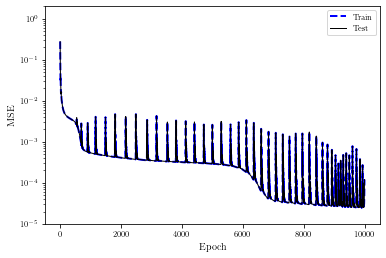

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


train_loss = np.array(train_loss_list)
test_loss =  np.array(test_loss_list)
plot_int = 1

ep = np.arange(0,nmax+1,1)
ep = ep[::plot_int]

train_loss_plot = train_loss[::plot_int]
test_loss_plot = train_loss[::plot_int]



gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_ylim([10**-5, 2])
ax.semilogy(ep, train_loss_plot, '--b', lw=2.0, label="Train")
ax.semilogy(ep, test_loss_plot, '-k', lw=1.0, label="Test")
plt.legend()
plt.savefig("Loss.png", dpi=300)
plt.show()



## DeepONet for Antiderivative Operators in JAX

In [8]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
from jax.example_libraries import optimizers
from jax import jit, grad, vmap, value_and_grad
from jax import random
import scipy.io as io
import time
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec


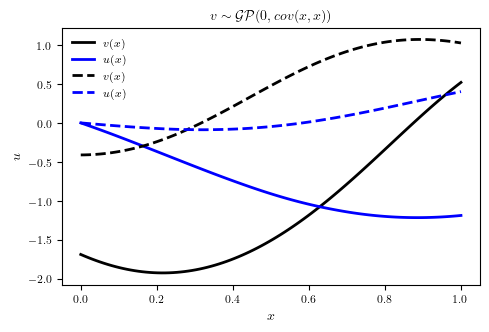

In [10]:
import numpy as np
import jax.numpy as jnp
# Load the data and visualize 
d = np.load("antiderivative_train.npz", allow_pickle=True)
v_train, x_train, u_train = jnp.array(d["X"][0]), \
jnp.array(d["X"][1]), jnp.array(d["y"])

d = np.load("antiderivative_test.npz", allow_pickle=True)
v_test, x_test, u_test = jnp.array(d["X"][0]),\
jnp.array(d["X"][1]), jnp.array(d["y"])

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1,1)
ax = plt.subplot(gs0[:, :])
ax.plot(x_train, v_train[10,:], '-k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_train[10,:], '-b', lw=2.0, label="$u(x)$")
ax.plot(x_train, v_test[100,:], '--k', lw=2.0, label="$v(x)$")
ax.plot(x_train, u_test[100,:], '--b', lw=2.0, label="$u(x)$")
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$v \sim \mathcal{GP}(0, cov(x,x))$', fontsize = 10)
plt.savefig("Data.png", dpi=300)
plt.show()

In [9]:
key = random.PRNGKey(1234)
initializer = jax.nn.initializers.glorot_normal()
def hyper_initial(layers):
    L = len(layers)
    W = []
    b = []
    for l in range(1, L):
        in_dim = layers[l-1]
        out_dim = layers[l]
        std = np.sqrt(2.0/(in_dim+out_dim))
        weight = initializer(key, (in_dim, out_dim), jnp.float32)*std
        bias = initializer(key, (1, out_dim), jnp.float32)*std
        W.append(weight)
        b.append(bias)
    return W, b
def fnn_B(X, W, b):
    inputs = X
    L = len(W)
    for i in range(L-1):
        outputs = jnp.dot(inputs, W[i]) + b[i]
        inputs = jnp.tanh(outputs)  
    Y = jnp.dot(inputs, W[-1]) + b[-1]     
    return Y

def fnn_T(X, W, b):
    inputs = X
    L = len(W)
    for i in range(L-1):
        outputs = jnp.dot(inputs, W[i]) + b[i]
        inputs = jnp.tanh(outputs)  # inputs to the next layer
    Y = jnp.dot(inputs, W[-1]) + b[-1]     
    return Y


def predict(params, data):
    W_branch, b_branch, W_trunk, b_trunk = params
    v, x = data
    u_out_branch = fnn_B(v, W_branch, b_branch) # predict on branch
    u_out_trunk = fnn_T(x, W_trunk, b_trunk) # predict on trunk
    u_pred = jnp.einsum('ik,jk->ik',u_out_branch, u_out_trunk) # matmul
    return u_pred

def loss(params, data, u):
    u_preds = predict(params, data)
    # print(u_preds)
    mse = jnp.mean(jnp.sum((u_preds - u)**2, axis = 1)) 
    # print(mse)
    return mse

@jit
def update(params, data, u, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, data, u)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value


#input dimension for Branch Net
u_dim = 100
#output dimension for Branch and Trunk Net
G_dim = 100
#Branch Net
layers_f = [u_dim] + [40]*2 + [G_dim]
# Trunk dim
x_dim = 1
#Trunk Net
layers_x = [x_dim] + [40]*2 + [G_dim]
W_branch, b_branch = hyper_initial(layers_f)
W_trunk, b_trunk =   hyper_initial(layers_x)
# Defining an optimizer in Jax
num_epochs = 10000
lr = 5e-4
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init([W_branch, b_branch, W_trunk, b_trunk])
params = get_params(opt_state)
train_loss, test_loss = [], []

start_time = time.time()

for epoch in range(num_epochs):
    params, opt_state, loss_val = update(params, [v_train, x_train], u_train, opt_state)
    train_loss.append(loss_val)
    if epoch % 100 ==0:
        epoch_time = time.time() - start_time
        u_train_pred = predict(params, [v_train, x_train])
        err_train = jnp.mean(jnp.linalg.norm(u_train - u_train_pred, 2, axis=1)/\
                             np.linalg.norm(u_train , 2, axis=1))
        u_test_pred = predict(params, [v_test, x_test])
        err_test = jnp.mean(jnp.linalg.norm(u_test - u_test_pred, 2, axis=1)/\
                            np.linalg.norm(u_test , 2, axis=1))
        test_loss_val = loss(params, [v_test, x_test], u_test)
        test_loss.append(test_loss_val)
        print("Epoch {} | T: {:0.6f} | Train MSE: {:0.4f} | \
        Test MSE: {:0.4f} | Train L2: {:0.4f} | Test L2: {:0.4f}"\
              .format(epoch, epoch_time, loss_val, test_loss_val, err_train, err_test))

NameError: name 'random' is not defined

train_loss = np.array(train_loss)
test_loss =  np.array(test_loss)
plot_int = 100

ep = np.arange(0,num_epochs,1)
ep = ep[::plot_int]

train_loss_plot = train_loss[::plot_int]
test_loss_plot = train_loss[::plot_int]



gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
#ax.set_ylim([10**-5, 1])
ax.semilogy(ep, train_loss_plot, '--b', lw=2.0, label="Train")
ax.semilogy(ep, test_loss_plot, '-k', lw=1.0, label="Test")
plt.legend()
plt.savefig("Loss.png", dpi=300)
plt.show()



pred = predict(params, [v_train, x_train])
u_test_pred = predict(params, [v_test, x_test])

############################
gs1 = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs1[:, :])

ax1.plot(x_test, u_test_pred[20, :], '-k', lw=2.0, label="Predicted $u(x)$")

for i in range(10,20):
    ax1.plot(x_test, u_test_pred[i, :], '-k', lw=2.0)

ax1.plot(x_test, u_test[20, :], '--r', lw=2.0, label="Actual $u(x)$")

for i in range(10,20):
    ax1.plot(x_train,u_test[i, :], '--r', lw=2.0)



ax1.set_xlabel('$x$')
ax1.set_ylabel('$u$')
ax1.legend(frameon=True, loc = 'best')
plt.savefig("predicted_and_deeponet.png", dpi=300)
plt.show()

####
gs2 = gridspec.GridSpec(1,1)
ax2 = plt.subplot(gs2[:, :])

ax2.plot(x_test, v_test[20, :], '-g', lw=2.0, label="$v(x)$")
for i in range(10,20):
    ax2.plot(x_test, v_test[i, :], '-g', lw=2.0)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$v(x)$')
ax2.legend(frameon=True, loc = 'best')
plt.savefig("forcing.png", dpi=300)

## Fourier Neural Operator (FNO) for Burgers Equation

$$v_{t+1}(x):=\sigma\left(W v_t(x)+\left(\mathcal{K}(a ; \phi) v_t\right)(x)\right), \quad \forall x \in D$$

$$\left(\mathcal{K}(a ; \phi) v_t\right)(x):=\int_D \kappa(x, y, a(x), a(y) ; \phi) v_t(y) \mathrm{d} y, \quad \forall x \in D$$

In [1]:
### Modified: Z Li(2020) is original code 

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from op_utilities import *
from torch.optim import Adam

torch.manual_seed(0)
np.random.seed(0)


################################################################
#  Fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, dtype=torch.cfloat))
    # Complex multiplication
    def compl_mul1d(self, d_in, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", d_in, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  \
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64

dataloader = MatReader('/Users/raj/Desktop/burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train),\
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),\
                                          batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width)
print(f"Number of Parameters: {count_params(model)}")
################################################################
# Training and Prediction
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x, y 
        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x, y 

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    t2 = default_timer()
    print(f"Epoch: {ep}, Epoch Time: {t2-t1}, Train MSE_Error: {train_mse}, Train_L2_Error :{train_l2}\
    Test L2 Error, {test_l2}")

# torch.save(model, 'model/ns_fourier_burgers')
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),\
                                          batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x, y

        out = model(x).view(-1)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        index = index + 1

Number of Parameters: 549569
Epoch: 0, Epoch Time: 14.620024703000126, Train MSE_Error: 0.05239602538873442, Train_L2_Error :0.31149250411987306    Test L2 Error, 0.05157776832580566
Epoch: 1, Epoch Time: 13.858728330000304, Train MSE_Error: 0.0009731728018959984, Train_L2_Error :0.04498428481817245    Test L2 Error, 0.031348470449447635
Epoch: 2, Epoch Time: 13.592703306999283, Train MSE_Error: 0.0004834700755600352, Train_L2_Error :0.03169135719537735    Test L2 Error, 0.03782920241355896
Epoch: 3, Epoch Time: 13.901903650999884, Train MSE_Error: 0.0004273433734488208, Train_L2_Error :0.033200765132904056    Test L2 Error, 0.022788591980934143
Epoch: 4, Epoch Time: 13.77153398900009, Train MSE_Error: 0.00022103046758275012, Train_L2_Error :0.020983734369277952    Test L2 Error, 0.01757157266139984
Epoch: 5, Epoch Time: 14.293234789000053, Train MSE_Error: 0.0002444037765963003, Train_L2_Error :0.025850333005189897    Test L2 Error, 0.02444742828607559
Epoch: 6, Epoch Time: 13.5191419

Epoch: 52, Epoch Time: 13.527786347000074, Train MSE_Error: 2.0653506999224193e-05, Train_L2_Error :0.00786219821870327    Test L2 Error, 0.009231035262346268
Epoch: 53, Epoch Time: 13.527693349000401, Train MSE_Error: 1.9743036282307004e-05, Train_L2_Error :0.00726815029233694    Test L2 Error, 0.0040234410017728805
Epoch: 54, Epoch Time: 13.444319460999395, Train MSE_Error: 1.9832906136798556e-05, Train_L2_Error :0.007670996271073818    Test L2 Error, 0.00968548223376274
Epoch: 55, Epoch Time: 13.519650425000691, Train MSE_Error: 2.8199466669320827e-05, Train_L2_Error :0.009428367920219899    Test L2 Error, 0.008918724209070205
Epoch: 56, Epoch Time: 13.429931966000368, Train MSE_Error: 2.1098147321936267e-05, Train_L2_Error :0.007975549273192882    Test L2 Error, 0.011385854631662369
Epoch: 57, Epoch Time: 13.362362250999468, Train MSE_Error: 3.2940571300059675e-05, Train_L2_Error :0.010723478898406028    Test L2 Error, 0.010023507177829743
Epoch: 58, Epoch Time: 14.0357959819994, T

Epoch: 104, Epoch Time: 13.44670648600004, Train MSE_Error: 5.560943379805394e-06, Train_L2_Error :0.004029711056500673    Test L2 Error, 0.003570251539349556
Epoch: 105, Epoch Time: 13.403208535000886, Train MSE_Error: 8.359730636584572e-06, Train_L2_Error :0.005228427536785603    Test L2 Error, 0.0072613762319087985
Epoch: 106, Epoch Time: 13.401372168000307, Train MSE_Error: 8.037305224206649e-06, Train_L2_Error :0.0051453090980649    Test L2 Error, 0.005536790117621422
Epoch: 107, Epoch Time: 13.48329097199894, Train MSE_Error: 7.847643287277606e-06, Train_L2_Error :0.005223925687372685    Test L2 Error, 0.0035650741308927538
Epoch: 108, Epoch Time: 13.506644627999776, Train MSE_Error: 7.4359142217872435e-06, Train_L2_Error :0.00498549435287714    Test L2 Error, 0.006000727191567421
Epoch: 109, Epoch Time: 13.362300327000412, Train MSE_Error: 6.341492746742006e-06, Train_L2_Error :0.004452314753085375    Test L2 Error, 0.004060877785086632
Epoch: 110, Epoch Time: 13.912400733999675

Epoch: 156, Epoch Time: 13.520039187000293, Train MSE_Error: 2.2598710978627423e-06, Train_L2_Error :0.0024298566952347753    Test L2 Error, 0.002476734332740307
Epoch: 157, Epoch Time: 13.466724063999209, Train MSE_Error: 1.8671501078415531e-06, Train_L2_Error :0.0021992601566016676    Test L2 Error, 0.0024438413605093958
Epoch: 158, Epoch Time: 13.483928638999714, Train MSE_Error: 2.1368286633105527e-06, Train_L2_Error :0.0023627751860767605    Test L2 Error, 0.002154220789670944
Epoch: 159, Epoch Time: 13.468007990000842, Train MSE_Error: 2.3267280448635575e-06, Train_L2_Error :0.002610485453158617    Test L2 Error, 0.002558855153620243
Epoch: 160, Epoch Time: 13.52620131399999, Train MSE_Error: 1.9960358036996695e-06, Train_L2_Error :0.002234807949513197    Test L2 Error, 0.00331804346293211
Epoch: 161, Epoch Time: 13.414442019999115, Train MSE_Error: 1.968401810472642e-06, Train_L2_Error :0.0023176499214023353    Test L2 Error, 0.0017484237253665923
Epoch: 162, Epoch Time: 13.5081

Epoch: 207, Epoch Time: 14.40127464699981, Train MSE_Error: 9.012503107896919e-07, Train_L2_Error :0.0013187231607735158    Test L2 Error, 0.001998642086982727
Epoch: 208, Epoch Time: 13.821409204001611, Train MSE_Error: 1.0233459687469805e-06, Train_L2_Error :0.0014037475809454917    Test L2 Error, 0.0011700770631432533
Epoch: 209, Epoch Time: 13.541214322000087, Train MSE_Error: 7.217567386419432e-07, Train_L2_Error :0.0010207335650920869    Test L2 Error, 0.0011274239607155323
Epoch: 210, Epoch Time: 13.55228230800094, Train MSE_Error: 9.304497658035871e-07, Train_L2_Error :0.0013369006626307964    Test L2 Error, 0.001347327195107937
Epoch: 211, Epoch Time: 13.449016120001033, Train MSE_Error: 9.339623602500069e-07, Train_L2_Error :0.0012854515882208943    Test L2 Error, 0.0011343956366181374
Epoch: 212, Epoch Time: 13.52201810799852, Train MSE_Error: 6.671550937653592e-07, Train_L2_Error :0.0009742542766034603    Test L2 Error, 0.0010048317909240722
Epoch: 213, Epoch Time: 13.52219

Epoch: 258, Epoch Time: 13.555144564001239, Train MSE_Error: 4.644855377478052e-07, Train_L2_Error :0.0006623266050592065    Test L2 Error, 0.0007492182031273842
Epoch: 259, Epoch Time: 13.400527904001137, Train MSE_Error: 4.4300582743517223e-07, Train_L2_Error :0.0006640432123094797    Test L2 Error, 0.0007756257615983486
Epoch: 260, Epoch Time: 13.704327164999995, Train MSE_Error: 5.150666480346899e-07, Train_L2_Error :0.0008638736307621002    Test L2 Error, 0.000937223481014371
Epoch: 261, Epoch Time: 14.562470122000377, Train MSE_Error: 4.952242754541203e-07, Train_L2_Error :0.0007813661405816674    Test L2 Error, 0.0007847452815622091
Epoch: 262, Epoch Time: 13.479448283000238, Train MSE_Error: 4.394322793643823e-07, Train_L2_Error :0.0006980657959356904    Test L2 Error, 0.0008964386582374573
Epoch: 263, Epoch Time: 13.461457720000908, Train MSE_Error: 4.676661559699369e-07, Train_L2_Error :0.0007361113009974361    Test L2 Error, 0.0008133691083639861
Epoch: 264, Epoch Time: 13.4

Epoch: 309, Epoch Time: 18.7158697699997, Train MSE_Error: 3.7168239416018876e-07, Train_L2_Error :0.0005431977841071784    Test L2 Error, 0.0007063056528568268
Epoch: 310, Epoch Time: 18.248583186999895, Train MSE_Error: 3.689922620253583e-07, Train_L2_Error :0.0005752918915823102    Test L2 Error, 0.0007576519064605236
Epoch: 311, Epoch Time: 18.657289974000378, Train MSE_Error: 3.7403465935170744e-07, Train_L2_Error :0.0005702779050916433    Test L2 Error, 0.0006928546726703644
Epoch: 312, Epoch Time: 19.194952551000824, Train MSE_Error: 3.8020493860813074e-07, Train_L2_Error :0.0005956291845068335    Test L2 Error, 0.0007589402049779892
Epoch: 313, Epoch Time: 19.426392535999184, Train MSE_Error: 3.6642980994372464e-07, Train_L2_Error :0.0005707115307450294    Test L2 Error, 0.0007508672028779984
Epoch: 314, Epoch Time: 18.837439498000094, Train MSE_Error: 3.594866569045507e-07, Train_L2_Error :0.0005606132131069899    Test L2 Error, 0.0006773923896253109
Epoch: 315, Epoch Time: 18

Epoch: 360, Epoch Time: 18.247870911000064, Train MSE_Error: 3.2868054859136466e-07, Train_L2_Error :0.00047941542696207763    Test L2 Error, 0.0006230654846876859
Epoch: 361, Epoch Time: 18.153415774999303, Train MSE_Error: 3.231544761206351e-07, Train_L2_Error :0.0004783974825404584    Test L2 Error, 0.0006083370372653008
Epoch: 362, Epoch Time: 18.192701080000916, Train MSE_Error: 3.2641495415930423e-07, Train_L2_Error :0.0004703212697058916    Test L2 Error, 0.0006104162847623229
Epoch: 363, Epoch Time: 19.086992716000168, Train MSE_Error: 3.4765478801546123e-07, Train_L2_Error :0.0005073621082119644    Test L2 Error, 0.0006315979361534119
Epoch: 364, Epoch Time: 19.25252610899952, Train MSE_Error: 3.255143920455339e-07, Train_L2_Error :0.0005048428634181619    Test L2 Error, 0.0006159316841512918
Epoch: 365, Epoch Time: 18.917329344998507, Train MSE_Error: 3.266601697404781e-07, Train_L2_Error :0.00047671121498569846    Test L2 Error, 0.0006281510647386312
Epoch: 366, Epoch Time: 

Epoch: 411, Epoch Time: 17.996380880000288, Train MSE_Error: 3.0323160213896474e-07, Train_L2_Error :0.0004406567760743201    Test L2 Error, 0.0005867011193186045
Epoch: 412, Epoch Time: 17.716114140001082, Train MSE_Error: 3.106232835392575e-07, Train_L2_Error :0.0004407099299132824    Test L2 Error, 0.0005905604362487792
Epoch: 413, Epoch Time: 17.486546277999878, Train MSE_Error: 3.053090398807967e-07, Train_L2_Error :0.00044037644332274795    Test L2 Error, 0.0005886446218937635
Epoch: 414, Epoch Time: 17.95234254800016, Train MSE_Error: 3.033454366985211e-07, Train_L2_Error :0.00044904116541147235    Test L2 Error, 0.0006143272761255503
Epoch: 415, Epoch Time: 18.26219452300029, Train MSE_Error: 3.0935061090531235e-07, Train_L2_Error :0.0004496643324382603    Test L2 Error, 0.0005970808584243059
Epoch: 416, Epoch Time: 18.51941916099895, Train MSE_Error: 3.0707695650278313e-07, Train_L2_Error :0.000449934474658221    Test L2 Error, 0.0005858477344736457
Epoch: 417, Epoch Time: 18.

Epoch: 462, Epoch Time: 19.193521696999596, Train MSE_Error: 2.967882704041358e-07, Train_L2_Error :0.00042048513097688554    Test L2 Error, 0.0005757885938510299
Epoch: 463, Epoch Time: 17.592180387000553, Train MSE_Error: 2.966331190634719e-07, Train_L2_Error :0.0004328942489810288    Test L2 Error, 0.0005772251216694713
Epoch: 464, Epoch Time: 18.022157751000123, Train MSE_Error: 2.978345515813885e-07, Train_L2_Error :0.00042282887315377594    Test L2 Error, 0.0005730408104136586
Epoch: 465, Epoch Time: 17.774127902001055, Train MSE_Error: 2.9613436407061046e-07, Train_L2_Error :0.00042352865263819696    Test L2 Error, 0.000584556651301682
Epoch: 466, Epoch Time: 18.02771133100032, Train MSE_Error: 2.983744193230109e-07, Train_L2_Error :0.000423742413520813    Test L2 Error, 0.0005725069949403405
Epoch: 467, Epoch Time: 18.865535909000755, Train MSE_Error: 2.9854078782420855e-07, Train_L2_Error :0.0004215638502500951    Test L2 Error, 0.0005856695305556059
Epoch: 468, Epoch Time: 19

In [17]:
scipy.io.savemat('burger_test.mat', mdict={'pred': pred.cpu().numpy()})

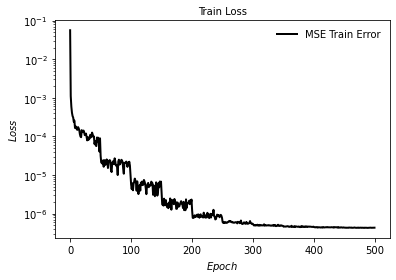

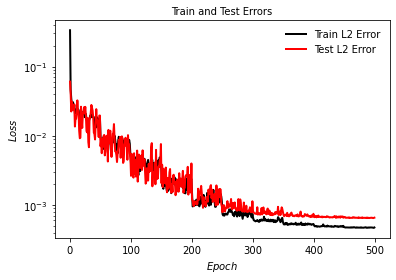

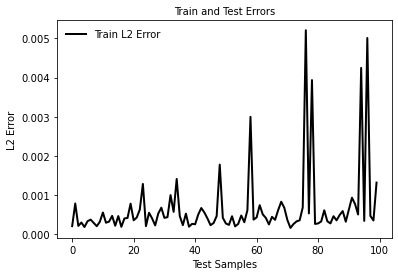

In [47]:
import matplotlib.gridspec as gridspec
ep,t, e_mse, trn_l2, tst_l2 = np.loadtxt("loss_err_fno.txt", delimiter=' ', usecols=(0, 1,2,3,4), unpack=True)
gs0 = gridspec.GridSpec(1,1)
ax = plt.subplot(gs0[:, :])
ax.semilogy(ep, e_mse, '-k', lw=2.0, label="MSE Train Error")
ax.set_xlabel('$Epoch$')
ax.set_ylabel('$Loss$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Train Loss', fontsize = 10)
plt.savefig("Train_Loss.png", dpi=300)

plt.show()
gs1 = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs1[:, :])
ax1.semilogy(ep, trn_l2, '-k', lw=2.0, label="Train L2 Error")
ax1.semilogy(ep, tst_l2, '-r', lw=2.0, label="Test L2 Error")

ax1.set_xlabel('$Epoch$')
ax1.set_ylabel('$Loss$')
ax1.legend(frameon=False, loc = 'best')
ax1.set_title('Train and Test Errors', fontsize = 10)
plt.savefig("Train_Test.png", dpi=300)

plt.show()

ba,e = np.loadtxt("eval_err.txt", delimiter=' ', usecols=(0, 1), unpack=True)
gs2 = gridspec.GridSpec(1,1)
ax2 = plt.subplot(gs1[:, :])
ax2.plot(ba, e, '-k', lw=2.0, label="Train L2 Error")

ax2.set_xlabel('Test Samples')
ax2.set_ylabel("L2 Error")
ax2.legend(frameon=False, loc = 'best')
ax2.set_title('Train and Test Errors', fontsize = 10)
plt.savefig("Error.png", dpi=300)

plt.show()


L2 Error is: 0.00020575149392243475


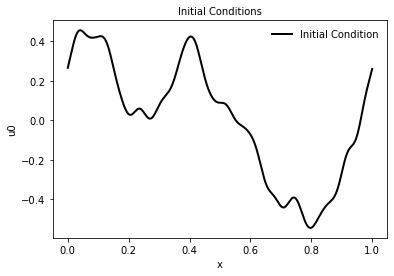

In [76]:
pred_u_plot = pred[0,:]
u_test_plot = y_test[0,:]
x_test_plot = x_test[0,:]
x_plot = np.linspace(0, 1, 1024)
err1 = np.linalg.norm(u_test_plot - pred_u_plot)
err2 = np.linalg.norm(u_test_plot)
err = err1/err2
print(f"L2 Error is: {err}")
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[:, :])
ax.plot(x_plot, pred_u_plot, '-k', lw=2.0, label="FNO Predicted")
ax.plot(x_plot, u_test_plot, '--b', lw=2.0, label="Actual Solution")
ax.set_xlabel('$x$')
ax.set_ylabel("u")
ax.legend(frameon=False, loc = 'best')
ax.set_title("Actual vs Predicetd $u$, T=1 with L2 Error = 0.0002", fontsize = 10)
plt.savefig("Solution", dpi=300)


gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[:, :])
ax1.plot(x_plot, x_test_plot, '-k', lw=2.0, label="Initial Condition")
ax1.set_xlabel('x')
ax1.set_ylabel("u0")
ax1.legend(frameon=False, loc = 'best')
ax1.set_title("Initial Conditions", fontsize = 10)
plt.savefig("Ic_test", dpi=300)
plt.show()


tensor([0.1210, 0.1235, 0.1259,  ..., 0.1138, 0.1163, 0.1188])

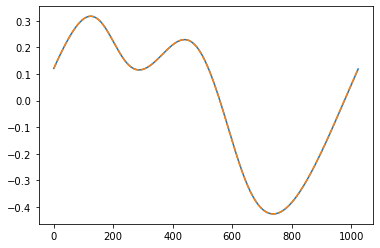

In [50]:
plt.plot(s1, "-")
plt.plot(s2,"--")